<h1>News Classification</h1>
<p>We present a Multinomial Naive Bayes Classifier and a Multi-Class Support Vector Machine for the purpose of categorizing news articles. </p>

<h2>Relevant Modules</h2>

In [1]:
#numpy and desired classifiers
import numpy as np
from scipy import stats
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import HashingVectorizer

#returns path of data directory, avoids downloading data multiple times
from sklearn.datasets import get_data_home
#scikit's url handeling
from sklearn.externals.six.moves.urllib.request import urlretrieve
#scikit's download of html parser(avoids dependency issues later)
from sklearn.externals.six.moves import html_parser

#regular expressions library
import re
#benchmarking
import time
#for efficient iterative evaluation, mirroring "lazy evaluation", so all data doesn't need to be stored at same time
import itertools
#finds pathnames that match a pattern; Unix pattern matching rules
from glob import glob
#interface with operating system to go down path on computer
import os.path
#read and write tarfiles, the email files format 
import tarfile


#graphing
import matplotlib.pyplot as plt
from matplotlib import rcParams
from __future__ import print_function
%matplotlib inline


<h2>Individual Email Parser</h2>

In [2]:
class EmailParser(html_parser.HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        html_parser.HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding


    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""
        
    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""
        
        
    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()
        
    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data
     
        
    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()




<h2>Data Download & Document Stream </h2>

In [3]:
def stream_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                    'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    
    def _not_in_sphinx():
        return '__file__' in globals()

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                print('\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb),
                      end='')

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urlretrieve(DOWNLOAD_URL, filename=archive_path,
                    reporthook=progress)
        if _not_in_sphinx():
            print('\r', end='')
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")

    #We have Iterator to avoid downloading whole dataset, which can be too expensive 
    parser = EmailParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc

<h3>Email Vectorization & Streaming</h3>

In [4]:
def vectorize(stop):
    if stop == True:
        vectorizer = HashingVectorizer(stop_words='english',decode_error='ignore', n_features=2 ** 18, alternate_sign=False)
    else:
        vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18, alternate_sign=False)

    # Define global variable
    global cls_stats, total_vect_time, parsing_time, vectorizing_time, n_test_documents
    
    # Iterator over parsed Reuters SGML files.
    data_stream = stream_documents()

    # We learn a binary classification between the "acq" class and all the others.
    # "acq" was chosen as it is more or less evenly distributed in the Reuters
    # files. For other datasets, one should take care of creating a test set with
    # a realistic portion of positive instances.
    all_classes = np.array([0, 1])
    positive_class = 'acq'

    # Here are some classifiers that support the `partial_fit` method
    partial_fit_classifiers = {
        'SGD': SGDClassifier(),
        'Perceptron': Perceptron(),
        'NB Multinomial': MultinomialNB(alpha=0.01),
    }


    def get_minibatch(doc_iter, size, pos_class=positive_class):
        """Extract a minibatch of examples, return a tuple X_text, y.

        Note: size is before excluding invalid docs with no topics assigned.

        """
        data = [(u'{title}\n\n{body}'.format(**doc), pos_class in doc['topics'])
                for doc in itertools.islice(doc_iter, size)
                if doc['topics']]
        if not len(data):
            return np.asarray([], dtype=int), np.asarray([], dtype=int)
        X_text, y = zip(*data)
        return X_text, np.asarray(y, dtype=int)


    def iter_minibatches(doc_iter, minibatch_size):
        """Generator of minibatches."""
        X_text, y = get_minibatch(doc_iter, minibatch_size)
        while len(X_text):
            yield X_text, y
            X_text, y = get_minibatch(doc_iter, minibatch_size)


    # test data statistics
    test_stats = {'n_test': 0, 'n_test_pos': 0}

    # First we hold out a number of examples to estimate accuracy
    n_test_documents = 1000
    tick = time.time()
    X_test_text, y_test = get_minibatch(data_stream, 1000)
    parsing_time = time.time() - tick
    tick = time.time()
    X_test = vectorizer.transform(X_test_text)
    vectorizing_time = time.time() - tick
    test_stats['n_test'] += len(y_test)
    test_stats['n_test_pos'] += sum(y_test)
    print("Test set is %d documents (%d positive)" % (len(y_test), sum(y_test)))


    def progress(cls_name, stats):
        """Report progress information, return a string."""
        duration = time.time() - stats['t0']
        s = "%20s classifier : \t" % cls_name
        s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
        s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
        s += "accuracy: %(accuracy).3f " % stats
        s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
        return s


    cls_stats = {}

    for cls_name in partial_fit_classifiers:
        stats = {'n_train': 0, 'n_train_pos': 0,
                 'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
                 'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
        cls_stats[cls_name] = stats

    get_minibatch(data_stream, n_test_documents)
    # Discard test set

    # We will feed the classifier with mini-batches of 1000 documents; this means
    # we have at most 1000 docs in memory at any time.  The smaller the document
    # batch, the bigger the relative overhead of the partial fit methods.
    minibatch_size = 1000

    # Create the data_stream that parses Reuters SGML files and iterates on
    # documents as a stream.
    minibatch_iterators = iter_minibatches(data_stream, minibatch_size)
    total_vect_time = 0.0

    # Main loop : iterate on mini-batches of examples
    for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

        tick = time.time()
        X_train = vectorizer.transform(X_train_text)

        total_vect_time += time.time() - tick

        for cls_name, cls in partial_fit_classifiers.items():
            tick = time.time()
            # update estimator with examples in the current mini-batch
            cls.partial_fit(X_train, y_train, classes=all_classes)

            # accumulate test accuracy stats
            cls_stats[cls_name]['total_fit_time'] += time.time() - tick
            cls_stats[cls_name]['n_train'] += X_train.shape[0]
            cls_stats[cls_name]['n_train_pos'] += sum(y_train)
            tick = time.time()
            cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
            cls_stats[cls_name]['prediction_time'] = time.time() - tick
            acc_history = (cls_stats[cls_name]['accuracy'],
                           cls_stats[cls_name]['n_train'])
            cls_stats[cls_name]['accuracy_history'].append(acc_history)
            run_history = (cls_stats[cls_name]['accuracy'],
                           total_vect_time + cls_stats[cls_name]['total_fit_time'])
            cls_stats[cls_name]['runtime_history'].append(run_history)
#
#            if i % 3 == 0:
 #               print(progress(cls_name, cls_stats[cls_name]))
 #       if i % 3 == 0:
 #           print('\n')
    

<h3>Visualize Results</h3>

In [5]:
def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)

def autolabel(ax,rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2.,
                1.05 * height, '%.4f' % height,
                ha='center', va='bottom')

def plot_acc_evo(cls_names):
    # Plot accuracy evolution
    plt.figure(figsize=(10,7))
    for _, stats in sorted(cls_stats.items()):
        # Plot accuracy evolution with #examples
        accuracy, n_examples = zip(*stats['accuracy_history'])
        plot_accuracy(n_examples, accuracy, "training examples (#)")
        ax = plt.gca()
        ax.set_ylim((0.8, 1))
    plt.legend(cls_names, loc='best')

def plot_acc_runtime(cls_names):
    plt.figure(figsize=(10,7))
    for _, stats in sorted(cls_stats.items()):
        # Plot accuracy evolution with runtime
        accuracy, runtime = zip(*stats['runtime_history'])
        plot_accuracy(runtime, accuracy, 'runtime (s)')
        ax = plt.gca()
        ax.set_ylim((0.8, 1))
    plt.legend(cls_names, loc='best')

def plot_fit_times(cls_names):
    # Plot fitting times
    plt.figure(figsize=(10,7))
    fig = plt.gcf()
    cls_runtime = []
    for cls_name, stats in sorted(cls_stats.items()):
        cls_runtime.append(stats['total_fit_time'])

    cls_runtime.append(total_vect_time)
    cls_names.append('Vectorization')
    bar_colors = ['b', 'g', 'r', 'c', 'm', 'y']

    ax = plt.subplot(111)
    rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                         color=bar_colors)

    ax.set_xticks(np.linspace(0.25, len(cls_names) - 0.75, len(cls_names)))
    ax.set_xticklabels(cls_names, fontsize=10)
    ymax = max(cls_runtime) * 1.2
    ax.set_ylim((0, ymax))
    ax.set_ylabel('runtime (s)')
    ax.set_title('Training Times')

    autolabel(ax,rectangles)
        
def plots_times():
    bar_colors = ['b', 'g', 'r', 'c', 'm', 'y']
    
    # Plot prediction times
    plt.figure(figsize=(10,7))
    cls_runtime = []
    cls_names = list(sorted(cls_stats.keys()))
    for cls_name, stats in sorted(cls_stats.items()):
        cls_runtime.append(stats['prediction_time'])
    cls_runtime.append(parsing_time)
    cls_names.append('Read/Parse\n+Feat.Extr.')
    cls_runtime.append(vectorizing_time)
    cls_names.append('Hashing\n+Vect.')

    ax = plt.subplot(111)
    rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                         color=bar_colors)

    ax.set_xticks(np.linspace(0.25, len(cls_names) - 0.75, len(cls_names)))
    ax.set_xticklabels(cls_names, fontsize=8)
    plt.setp(plt.xticks()[1], rotation=30)
    ymax = max(cls_runtime) * 1.2
    ax.set_ylim((0, ymax))
    ax.set_ylabel('runtime (s)')
    ax.set_title('Prediction Times (%d instances)' % n_test_documents)
    
    autolabel(ax,rectangles)

In [6]:
# Plot results for run with stop words
vectorize(True);

Test set is 878 documents (108 positive)


C:\Users\danis_000\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\danis_000\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [7]:
rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

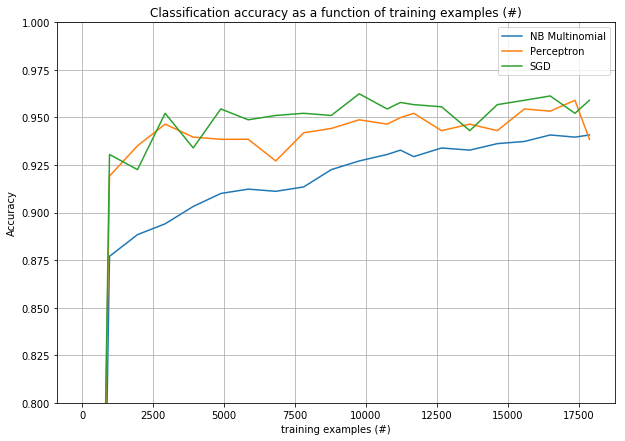

In [8]:
plot_acc_evo(cls_names)

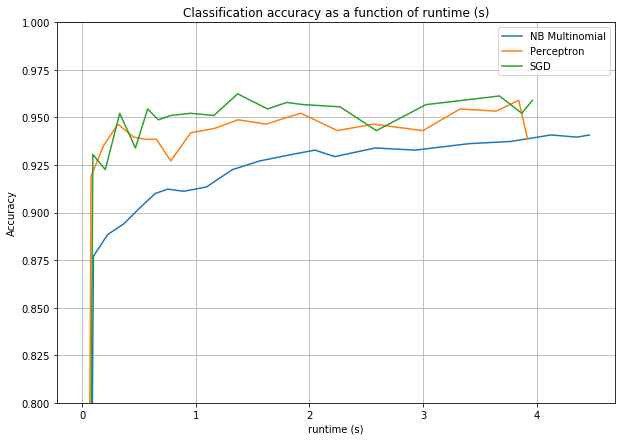

In [9]:
plot_acc_runtime(cls_names)

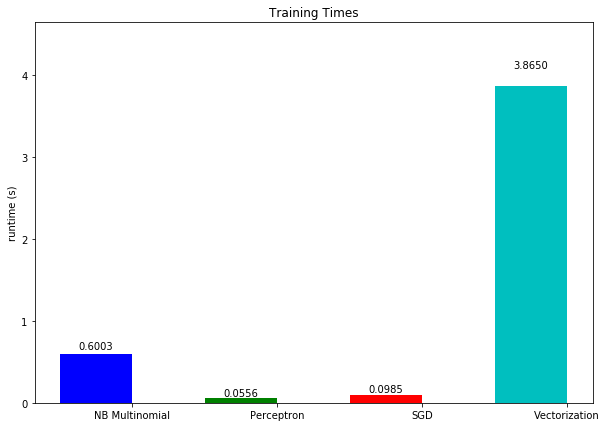

In [10]:
plot_fit_times(cls_names)

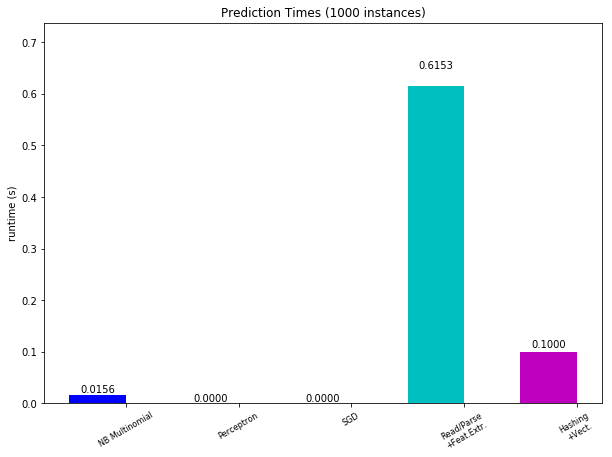

In [11]:
plots_times()

In [12]:
# Plot results for run with stop words
vectorize(False)

Test set is 878 documents (108 positive)


C:\Users\danis_000\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\danis_000\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [13]:
rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

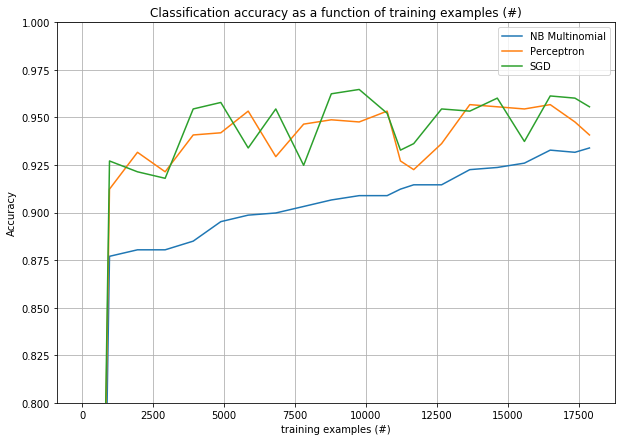

In [14]:
plot_acc_evo(cls_names)

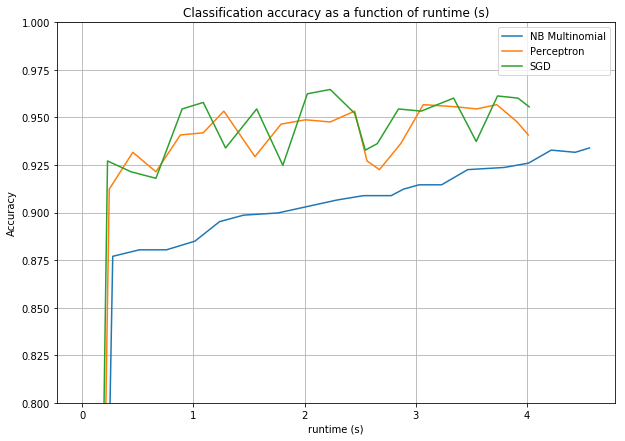

In [15]:
plot_acc_runtime(cls_names)

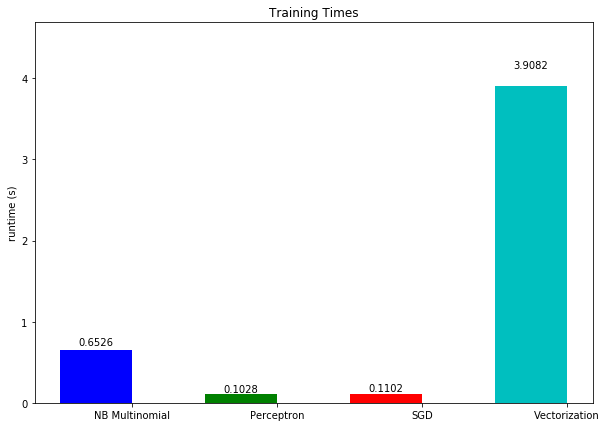

In [16]:
plot_fit_times(cls_names)

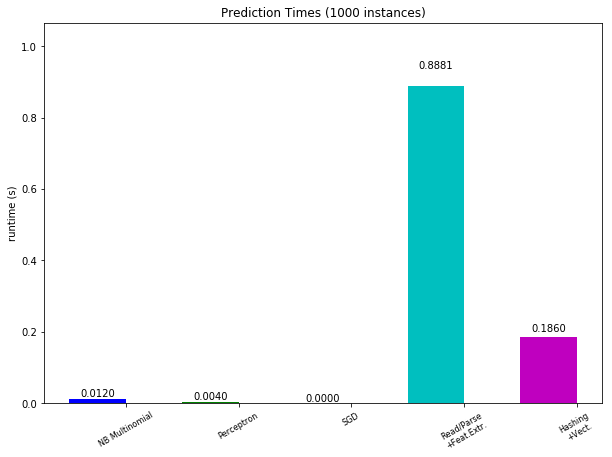

In [17]:
plots_times()